# Cloud Statistics

This notebook explores Landsat-7 and Landsat-8 Data Cubes and reports cloud statistics for selected regions within a cube. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

import xarray as xr

In [10]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

product = "ls8_lasrc_kenya"
platform = "LANDSAT_8"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

In [11]:
# Print extents of the Data Cube
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print(latitude_extents)
print(longitude_extents)
print(time_extents)

(-4.997106940467012, 5.996881030410326)
(32.98674340708594, 41.9828951536269)
(numpy.datetime64('2013-04-12T07:50:21.000000000'), numpy.datetime64('2020-01-19T07:42:56.000000000'))


In [5]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Kumasi, Ghana
# latitude = (6.529, 6.8734) 
# longitude = (-1.7954, -1.4211)

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Mining Region near Obuasi, Ghana
latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)

# Time Period
time_extents = ('2019-01-01', '2019-12-31')

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Calculate cloud coverage percentage for each pixel 

In [7]:
import datacube
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 
import numpy as np
from functools import partial  
import pandas as pd

def build_cloud_coverage_table_landsat(product   = None,
                               platform  = None,
                               latitude  = None,
                               longitude = None,
                               time     = None,
                               dc       = None,
                               extra_band = 'green'):
    
    if product   is None: raise Exception("product argument is required")
    if platform  is None: raise Exception("platform argument is required")
    if latitude  is None: raise Exception("latitude argument is required")
    if longitude is None: raise Exception("longitude argument is required")
 
    def clean_mask(ds, unpacking_func, bands):
        masks = [unpacking_func(ds, band) for band in bands]
        return np.logical_or(*masks).values
    
    unpack_function = {"LANDSAT_7": ls7_unpack_qa,
                       "LANDSAT_8": ls8_unpack_qa}

    dc = datacube.Datacube(app = "")
    
    load_params = dict(product = product,
                       platform = platform,
                       latitude = latitude,
                       longitude = longitude,
                       measurements = [extra_band, 'pixel_qa'])
    
    if time is not None: 
        load_params["time"] = time
        
    geo_data = dc.load(**load_params)
    
    times = list(geo_data.time.values)
    scene_slice_list = list(map(lambda t: geo_data.sel(time = t), times))
    
    def create_clean_mask_list(ds):
        return clean_mask(ds, unpacking_func = unpack_function[platform], bands = ["clear", "water"])
    clean_mask_list = list(map(lambda ds: create_clean_mask_list(ds.pixel_qa), scene_slice_list))
    no_data_mask_list = list(map(lambda ds: (ds[extra_band]==-9999).values, scene_slice_list))
    # This method of creating `percentage_list` gives the percentage of pixels with data (i.e. not no_data (-9999))
    # which are also not cloud.
#     def create_clean_percentage_with_data_list(masks_tup):
#         """Merges two masks - passed as a tuple - and calculates the percentage
#            of pixels that are clean and have data."""
#         clean_mask, no_data_mask = masks_tup
#         merged_mask = clean_mask & ~no_data_mask
#         return merged_mask.sum() / (~no_data_mask).sum() * 100
#     percentage_list = list(map(create_clean_percentage_with_data_list, 
#                                zip(clean_mask_list, no_data_mask_list)))
    # This method of creating `percentage_list` gieves the percentage of all pixels 
    # which are also not cloud.
    percentage_list = [clean_mask.mean()*100 for clean_mask in clean_mask_list]
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    
    data = {"times": times,
            # "clean_percentage" is the percent of pixels that are not no_data which are clear.
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return geo_data, pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [8]:
extra_band = 'green'
landsat_dataset, coverage_table = build_cloud_coverage_table_landsat(product = product,
                                                                  platform = platform,
                                                                  latitude = latitude,
                                                                  longitude = longitude,
                                                                  time = time_extents,
                                                                  extra_band=extra_band)

## Create a table of cloud coverage percentage for each date

In [9]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2019-01-06 10:21:44,99.372222,433720
1,2019-01-22 10:21:41,13.543280,59111
2,2019-02-07 10:21:38,42.152316,183978
3,2019-03-11 10:21:29,93.502726,408102
4,2019-03-27 10:21:26,73.721761,321766
5,2019-04-12 10:21:21,22.161252,96725
6,2019-04-28 10:21:16,36.417541,158948
7,2019-05-14 10:21:26,70.393392,307239
8,2019-05-30 10:21:35,0.074234,324
9,2019-06-15 10:21:42,0.679100,2964


## Create a plot of cloud coverage percentage for each date

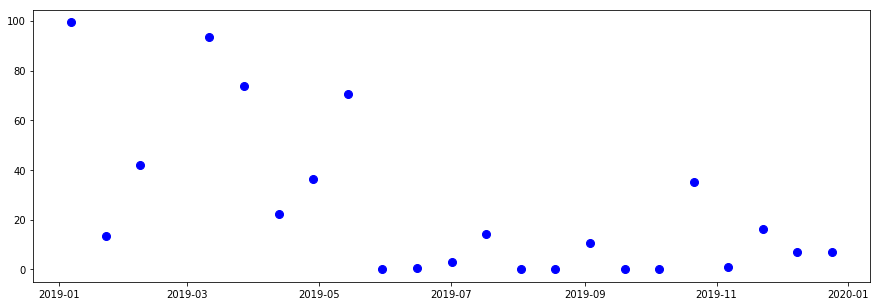

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

## Review an RGB scene for a selected time slice

In [11]:
# Load the data to create an RGB image
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']) 

In [12]:
from utils.data_cube_utilities.dc_rgb import rgb

In [13]:
# Review the contents of the dataset
# Latitude and Longitude dimensions are in pixels
# Time dimension is the number of acquisitions in the time period
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 628, longitude: 695, time: 22)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-06T10:21:44 ... 2019-12-24T10:22:08
  * latitude   (latitude) float64 6.268 6.267 6.267 6.267 ... 6.099 6.099 6.099
  * longitude  (longitude) float64 -2.05 -2.05 -2.049 ... -1.863 -1.863 -1.863
Data variables:
    red        (time, latitude, longitude) int16 684 594 682 ... 907 647 1205
    green      (time, latitude, longitude) int16 713 671 701 ... 998 812 1336
    blue       (time, latitude, longitude) int16 364 369 391 ... 575 466 1251
    nir        (time, latitude, longitude) int16 2641 2778 2526 ... 3545 3380
    swir1      (time, latitude, longitude) int16 2029 1855 1988 ... 1995 2163
    swir2      (time, latitude, longitude) int16 1255 997 1154 ... 1114 1373
Attributes:
    crs:      EPSG:4326

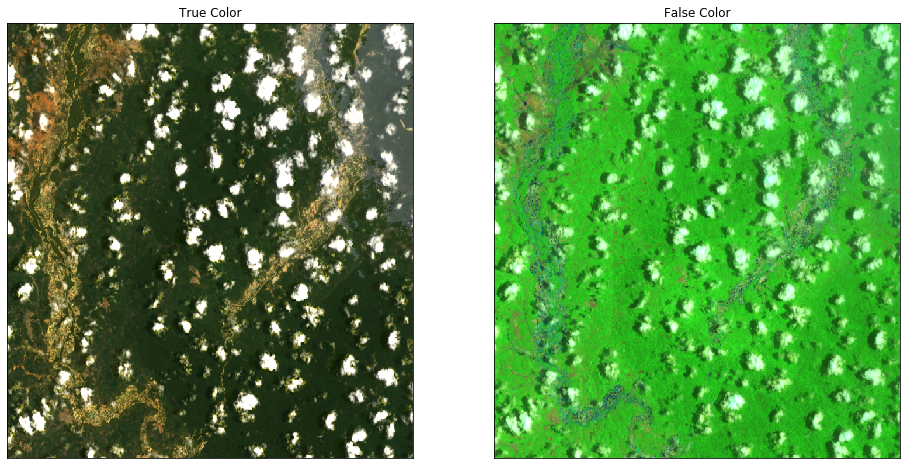

In [17]:
# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE for an RGB image

# RGB image options
# True-Color RGB = Red, Green, Blue
# False Color RGB (Landsat Mosaic) = SWIR2, NIR, Green

slice = 4  # select the time slice number here

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb = landsat_dataset.isel(time=slice)[['red', 'green', 'blue']].to_array()
false_rgb = landsat_dataset.isel(time=slice)[['swir2', 'nir', 'green']].to_array()
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=3000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()